Organisé comme suit : 

    - Imports, à compiler avant toute chose
    - Description de détection des trajectoires circulaires suivant les critères : une vitesse de rotation supérieur à un tour par minute et une minute continue de rotation minimum. Cf rapport section processing flights.
    - Analyse de l'importance du seuil accépté de un tour par minute comme vistesse de rotation
    - Construction d'une base de données de thermiques en netcdf
    - Cartes des vitesses U,V,W intégrées sur 4h dans l'après midi chaque jours
    - Gif 

## Imports 

In [49]:
from reader import Reader
import igc_lib
from base_Imports_and_Functions import *

Thermals_db = xr.open_dataset(savenet_path +'Thermals_data_base.nc')
Elevation_father = xr.open_dataset('T:/C2H/STAGES/LEO_BARROIS/netcds/Elevation_father.nc')
Th_19 = xr.open_dataset(savenet_path +'Thermals_19.nc')
Th_20 = xr.open_dataset(savenet_path +'Thermals_20.nc')
Th_21 = xr.open_dataset(savenet_path +'Thermals_21.nc')
Th_22 = xr.open_dataset(savenet_path +'Thermals_22.nc')
Th_23 = xr.open_dataset(savenet_path +'Thermals_23.nc')
Th_24 = xr.open_dataset(savenet_path +'Thermals_24.nc')

## Detecting thermals

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (16,14), layout = 'constrained')

### Parapente

a = np.load('T:/C2H/STAGES/LEO_BARROIS/ndarray/traces_new_reader/IGC_19-08-2023/Parapente/1692472436.54_64e1147482bd9.igc.npy')

lon_series = np.array(a[:,0])
lat_series = np.array(a[:,1])
alt_series = np.array(a[:,2])
raw_t = np.array(a[:,4])

min_bear = 6

lons_ = smooth(lon_series,window_len=11,window='hanning')
lats_ = smooth(lat_series,window_len=11,window='hanning')
alts_ = smooth(remove_zero_from_alti(alt_series),window_len=11,window='hanning')

speed_ = compute_v(lons_,lats_,alts_,raw_t)
bearing_rates_l = smooth(bearing_rate(speed_),window_len=20,window='hanning')

ind1 = (bearing_rates_l[1000:1500] <= min_bear)
ind2 = (bearing_rates_l[1000:1500] > min_bear)
bearing_rates_l_acc = np.ma.masked_array(bearing_rates_l[1000:1500],mask=ind1)
bearing_rates_l_ref = np.ma.masked_array(bearing_rates_l[1000:1500],mask=ind2)

lon_acc = np.ma.masked_array(lons_[1000+1:1500+1],mask=ind1)
lon_ref = np.ma.masked_array(lons_[1000+1:1500+1],mask=ind2)
lat_acc = np.ma.masked_array(lats_[1000+1:1500+1],mask=ind1)
lat_ref = np.ma.masked_array(lats_[1000+1:1500+1],mask=ind2)

ax1 = axs[0,0]
ax1.plot(lon_ref,lat_ref, 'r', label ='Glide')
ax1.plot(lon_acc,lat_acc, 'g', label ='Thermal')
ax1.set_xlabel('°E')
ax1.set_ylabel('°N')
ax1.set_title('Paragliding trajectory')

ax2 = axs[0,1]
ax2.plot(bearing_rates_l_ref, 'r')
ax2.plot(bearing_rates_l_acc, 'g')
ax2.plot([min_bear for i in range(500)],'k--',label = 'Min turning speed threshold '+ str(min_bear) + ' $°.s^{-1}$')

ref_duration_indices = find_consecutive(ind1,False)

legend_it = 0 
for i in ref_duration_indices :
    if legend_it == 0 :
        ax1.plot(lons_[1000+1+i[0]:1000+1+i[1]],lats_[1000+1+i[0]:1000+1+i[1]],color = 'purple', label ='Short thermal')
        ax2.plot(np.arange(i[0],i[1],1),bearing_rates_l[1000+i[0]:1000+i[1]],color = 'purple', label = 'Thermal duration < 60 s')
    else :
        ax1.plot(lons_[1000+1+i[0]:1000+1+i[1]],lats_[1000+1+i[0]:1000+1+i[1]],color = 'purple')
    ax2.plot(np.arange(i[0],i[1],1),bearing_rates_l[1000+i[0]:1000+i[1]],color = 'purple')
    legend_it += 1 
    
ax1.legend()

ax2.plot(lon_ref,lat_ref, 'r', label = 'Glide')
ax2.plot(lon_acc,lat_acc, 'g', label = 'Thermal')
ax2.set_xlabel('Indicative raw time (s)')
ax2.set_ylabel('Turning speed ($°.s^{-1}$)')
ax2.set_title('Turning speed')
ax2.legend()

ax2.set_ylim((2,23.5))

### Planeur

a = np.load('T:/C2H/STAGES/LEO_BARROIS/ndarray/traces_new_reader/IGC_19-08-2023/Planeur/2023-08-19 Eva Senne 325480.igc.npy')

lon_series = np.array(a[:,0])
lat_series = np.array(a[:,1])
alt_series = np.array(a[:,2])
raw_t = np.array(a[:,4])

min_bear = 6

lons_ = smooth(lon_series,window_len=11,window='hanning')
lats_ = smooth(lat_series,window_len=11,window='hanning')
alts_ = smooth(remove_zero_from_alti(alt_series),window_len=11,window='hanning')

speed_ = compute_v(lons_,lats_,alts_,raw_t)
bearing_rates_l = smooth(bearing_rate(speed_),window_len=20,window='hanning')

ind1 = (bearing_rates_l[830:1600] <= min_bear)
ind2 = (bearing_rates_l[830:1600] > min_bear)
bearing_rates_l_acc = np.ma.masked_array(bearing_rates_l[830:1600],mask=ind1)
bearing_rates_l_ref = np.ma.masked_array(bearing_rates_l[830:1600],mask=ind2)

lon_acc = np.ma.masked_array(lons_[830+1:1600+1],mask=ind1)
lon_ref = np.ma.masked_array(lons_[830+1:1600+1],mask=ind2)
lat_acc = np.ma.masked_array(lats_[830+1:1600+1],mask=ind1)
lat_ref = np.ma.masked_array(lats_[830+1:1600+1],mask=ind2)

ax1 = axs[1,0]
ax1.plot(lon_ref,lat_ref, 'r', label = 'Glide')
ax1.plot(lon_acc,lat_acc, 'g', label = 'Thermal')
ax1.set_xlabel('°E')
ax1.set_ylabel('°N')
ax1.set_title('Gliding trajectory')
ax1.legend()

ax2 = axs[1,1]
ax2.plot(bearing_rates_l_ref, 'r')
ax2.plot(bearing_rates_l_acc, 'g')
ax2.plot([min_bear for i in range(770)],'k--',label = 'Min turning speed threshold '+ str(min_bear) + ' $°.s^{-1}$')
ax2.plot(lon_ref,lat_ref, 'r', label = 'Glide')
ax2.plot(lon_acc,lat_acc, 'g', label = 'Thermal')
ax2.legend()
ax2.set_xlabel('Indicative raw time (s)')
ax2.set_ylabel('Turning speed ($°.s^{-1}$)')
ax2.set_title('Turning speed')
ax2.set_ylim((0,18))

for i in range(4):
    ax = axs[i//2,i%2]
    ax.text(-0.1, 1.1, string.ascii_lowercase[i], transform=ax.transAxes, 
            size=20, weight='bold')
    
plt.savefig(savefig_path+'thermal_threshold.png')

## bearing rate threshold 

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.95it/s]


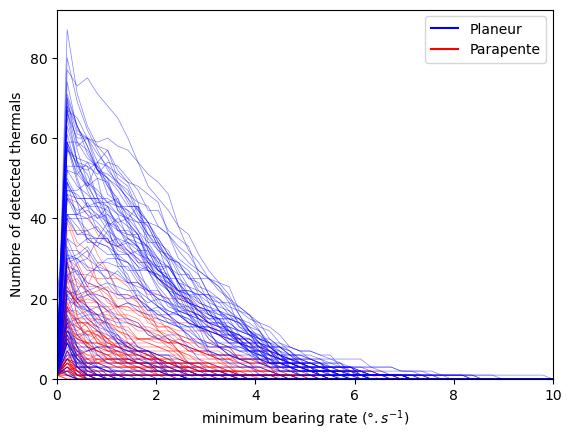

In [35]:
from tqdm import tqdm

dir = 'T:/C2H/STAGES/LEO_BARROIS/ndarray/traces_new_reader/IGC_19-08-2023/Parapente/'
dir2 = 'T:/C2H/STAGES/LEO_BARROIS/ndarray/traces_new_reader/IGC_19-08-2023/Planeur/'

liste_files = [dir + f for f in os.listdir(dir) if f.endswith('.npy')]
liste_files_plan = [dir2 + f for f in os.listdir(dir2) if f.endswith('.npy')]

min_bearing_rate_liste = np.linspace(0,10,50)

max = 0

for file in tqdm(liste_files[:100]) :
    if os.path.getsize(file) > 1800 :
        a = np.load(file)
        lon_series = np.array(a[:,0])
        lat_series = np.array(a[:,1])
        alt_series = np.array(a[:,2])
        raw_t = np.array(a[:,4])
        
        lon_ = smooth(lon_series,window_len=11,window='hanning')
        lat_ = smooth(lat_series,window_len=11,window='hanning')
        alt_ = smooth(remove_zero_from_alti(alt_series),window_len=11,window='hanning')
        raw_t = np.array(a[:,4])
    
        speed = compute_v(lon_,lat_,alt_,raw_t)
    
        bearing_rate_l = bearing_rate(speed)
    
        thermals = np.zeros((1,len(min_bearing_rate_liste)))[0]
        
        for count,b_rate in enumerate(min_bearing_rate_liste):
            
            nbre_th = 0
            min_bearing_rate = b_rate
            k = 0
            while k < len(bearing_rate_l):
                i = 0
                if bearing_rate_l[k] > min_bearing_rate :
                    while bearing_rate_l[k+i] > min_bearing_rate :
                        i +=1
                if i > 60 :
                    nbre_th = nbre_th + 1
                k = k+i+1

            if nbre_th > max :
                max = nbre_th
                
            thermals[count] = nbre_th
    
        plt.plot(min_bearing_rate_liste,thermals,'r',alpha = 0.5,linewidth = 0.5)

for file in tqdm(liste_files_plan[:100]) :
    if os.path.getsize(file) > 1000 :
        a = np.load(file)
        lon_series = np.array(a[:,0])
        lat_series = np.array(a[:,1])
        alt_series = np.array(a[:,2])
        raw_t = np.array(a[:,4])
        
        lon_ = smooth(lon_series,window_len=11,window='hanning')
        lat_ = smooth(lat_series,window_len=11,window='hanning')
        alt_ = smooth(remove_zero_from_alti(alt_series),window_len=11,window='hanning')
        raw_t = np.array(a[:,4])
    
        speed = compute_v(lon_,lat_,alt_,raw_t)
    
        bearing_rate_l = bearing_rate(speed)
    
        thermals = np.zeros((1,len(min_bearing_rate_liste)))[0]
        
        for count,b_rate in enumerate(min_bearing_rate_liste):
            
            nbre_th = 0
            min_bearing_rate = b_rate
            k = 0
            while k < len(bearing_rate_l):
                i = 0
                if bearing_rate_l[k] > min_bearing_rate :
                    while bearing_rate_l[k+i] > min_bearing_rate :
                        i +=1
                if i > 60 :
                    nbre_th = nbre_th + 1
                k = k+i+1

            if nbre_th > max :
                max = nbre_th
                
            thermals[count] = nbre_th
    
        plt.plot(min_bearing_rate_liste,thermals,'b',alpha = 0.5,linewidth = 0.5)

plt.plot([-5,-2],[-5,-2],'b',label ='Planeur')
plt.plot([-5,-2],[-5,-2],'r',label ='Parapente')
plt.xlim((0,10))
plt.ylim((0,max+5))
plt.legend()
plt.xlabel('minimum bearing rate ($°.s^{-1}$)')
plt.ylabel('Numbre of detected thermals')
plt.show()

In [39]:
dir = 'T:/C2H/STAGES/LEO_BARROIS/ndarray/traces_new_reader/IGC_19-08-2023/Parapente/'
dir2 = 'T:/C2H/STAGES/LEO_BARROIS/ndarray/traces_new_reader/IGC_19-08-2023/Planeur/'

liste_files = [dir + f for f in os.listdir(dir) if f.endswith('.npy')]
liste_files_plan = [dir2 + f for f in os.listdir(dir2) if f.endswith('.npy')]

min_bearing_rate_liste = np.linspace(1,20,50)

max = 0

all_para = [[] for i in range(len(min_bearing_rate_liste))]
all_plan = [[] for i in range(len(min_bearing_rate_liste))]

for file in tqdm(liste_files) :
    if os.path.getsize(file) > 1800 :
        a = np.load(file)
        lon_series = np.array(a[:,0])
        lat_series = np.array(a[:,1])
        alt_series = np.array(a[:,2])
        raw_t = np.array(a[:,4])
        
        lon_ = smooth(lon_series,window_len=11,window='hanning')
        lat_ = smooth(lat_series,window_len=11,window='hanning')
        alt_ = smooth(remove_zero_from_alti(alt_series),window_len=11,window='hanning')
        raw_t = np.array(a[:,4])
    
        speed = compute_v(lon_,lat_,alt_,raw_t)
    
        bearing_rate_l = smooth(bearing_rate(speed),window_len=20,window='hanning')
    
        thermals = np.zeros((1,len(min_bearing_rate_liste)))[0]
        
        for count,b_rate in enumerate(min_bearing_rate_liste):
            
            nbre_th = 0
            min_bearing_rate = b_rate
            k = 0
            while k < len(bearing_rate_l):
                i = 0
                if bearing_rate_l[k] > min_bearing_rate :
                    while k+i < len(bearing_rate_l) and  bearing_rate_l[k+i] > min_bearing_rate :
                        i +=1
                if i > 60 :
                    nbre_th = nbre_th + 1
                k = k+i+1
                
            thermals[count] = nbre_th
            all_para[count].append(nbre_th)
    
#        plt.plot(min_bearing_rate_liste,thermals,'r',alpha = 0.5,linewidth = 0.5)

median_para = [np.percentile(all_para[count],50) for count in range(len(all_para))]

if np.max(median_para) > max :
    max = np.max(median_para)

for file in tqdm(liste_files_plan) :
    if os.path.getsize(file) > 1800 :
        a = np.load(file)
        lon_series = np.array(a[:,0])
        lat_series = np.array(a[:,1])
        alt_series = np.array(a[:,2])
        raw_t = np.array(a[:,4])
        
        lon_ = smooth(lon_series,window_len=11,window='hanning')
        lat_ = smooth(lat_series,window_len=11,window='hanning')
        alt_ = smooth(remove_zero_from_alti(alt_series),window_len=11,window='hanning')
        raw_t = np.array(a[:,4])
    
        speed = compute_v(lon_,lat_,alt_,raw_t)
    
        bearing_rate_l = bearing_rate(speed)
    
        thermals = np.zeros((1,len(min_bearing_rate_liste)))[0]
        
        for count,b_rate in enumerate(min_bearing_rate_liste):
            
            nbre_th = 0
            min_bearing_rate = b_rate
            k = 0
            while k < len(bearing_rate_l):
                i = 0
                if bearing_rate_l[k] > min_bearing_rate :
                    while k+i < len(bearing_rate_l) and  bearing_rate_l[k+i] > min_bearing_rate :
                        i +=1
                if i > 60 :
                    nbre_th = nbre_th + 1
                k = k+i+1

            if nbre_th > max :
                max = nbre_th
                
            thermals[count] = nbre_th
            all_plan[count].append(nbre_th)
    
#        plt.plot(min_bearing_rate_liste,thermals,'b',alpha = 0.5,linewidth = 0.5)

if np.max(median_plan) > max :
    max = np.max(median_plan)

100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [01:16<00:00,  2.00it/s]


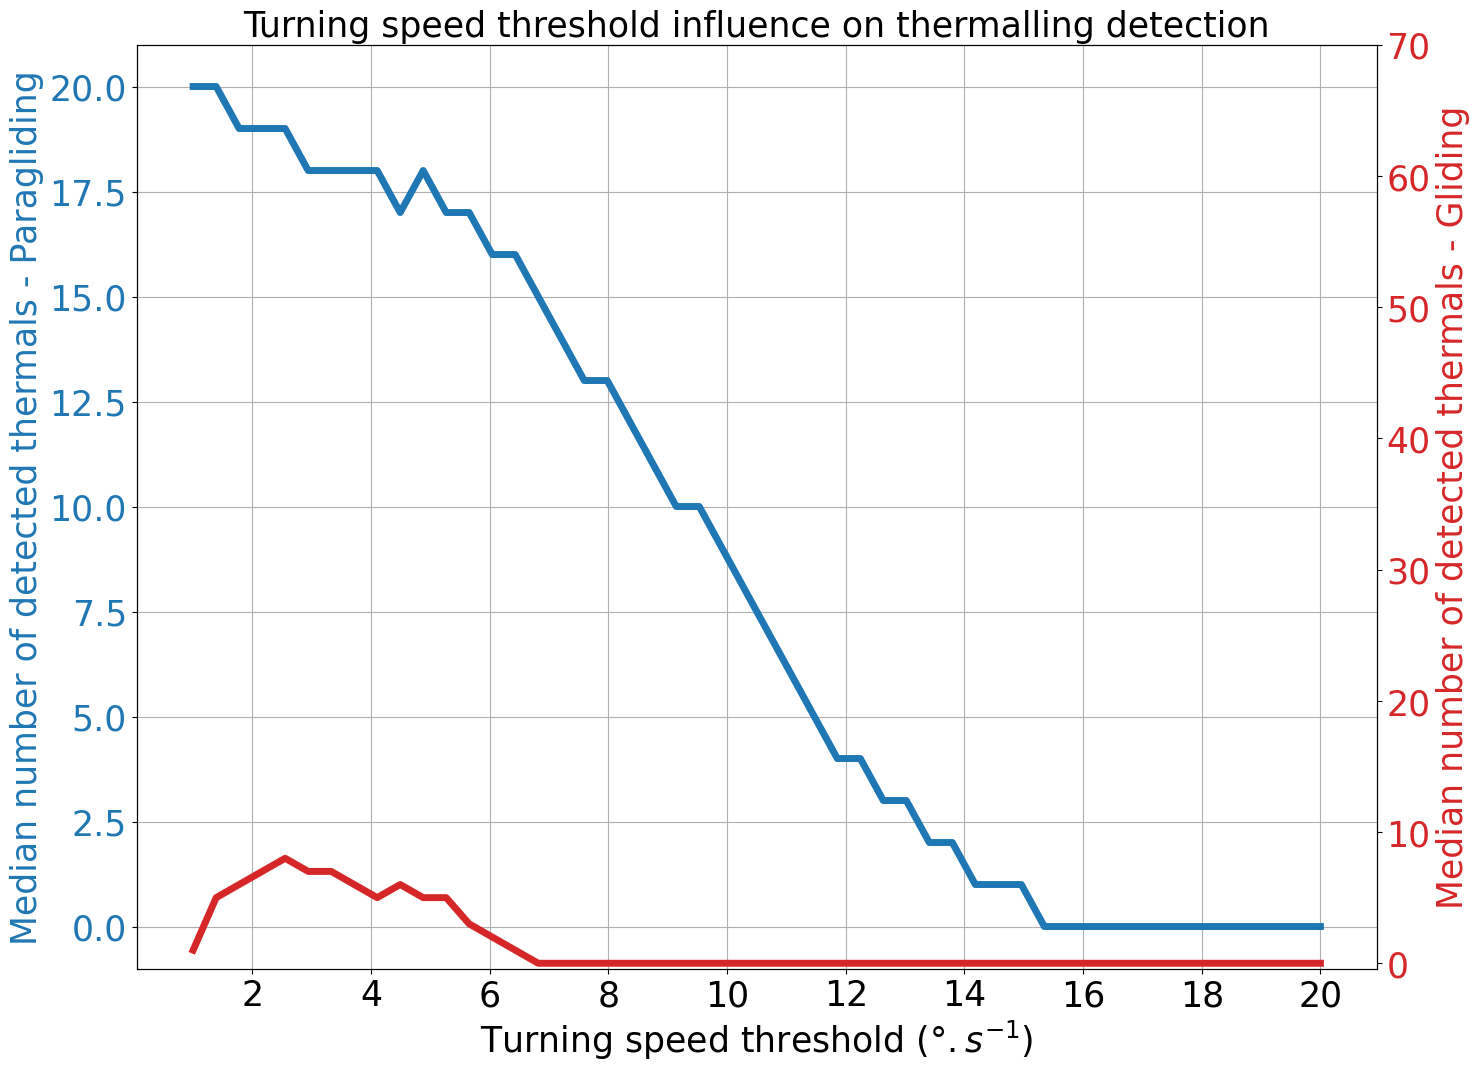

In [40]:
fig, ax = plt.subplots(figsize=(16, 12))

size = 25

color = 'tab:blue'
yticks = np.array([i*2.5 for i in range(9)])
ylabels = [str(i) for i in yticks]
xticks = np.array([i*2 for i in range(1,11)])
xlabels = [str(i) for i in xticks]
ax.plot(min_bearing_rate_liste,median_para,color = color,linewidth=5)
ax.set_xlabel('Turning speed threshold ($°.s^{-1}$)',fontsize = size)
ax.set_ylabel('Median number of detected thermals - Paragliding', color = color,fontsize = size)
ax.tick_params(axis='y', labelcolor=color)
ax.set_yticks(yticks, ylabels,fontsize=size)
ax.set_xticks(xticks, xlabels,fontsize=size)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
yticks = np.array([i*10 for i in range(8)])
ylabels = [str(i) for i in yticks]
ax2.set_ylabel('Median number of detected thermals - Gliding', color=color,fontsize = size)  # we already handled the x-label with ax1
ax2.plot(min_bearing_rate_liste,median_plan, color=color,linewidth=5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks(yticks, ylabels,fontsize=size)
ax.grid(True)

plt.title('Turning speed threshold influence on thermalling detection', fontsize = size)

plt.savefig(savefig_path+'thermal_method.png')
plt.show()

## Thermal database

### All to netcdf

In [ ]:
days = ['IGC_19-08-2023/','IGC_20-08-2023/','IGC_21-08-2023/','IGC_22-08-2023/','IGC_23-08-2023/','IGC_24-08-2023/']
data_path = 'C:/Users/barroisl/Documents/Stage_Léo/Vols/'
type_vols = ['Parapente/','Planeur/']

index_g = 0
rawtime = []
latitude = []
longitude = []
altitude_gnss = []
altitude_pres = []
dayofflight = []
type = []
index = []
for i in range(6):
    for j in range(2):  
        directory = data_path + days[i] + type_vols[j]
        liste_file = [directory+f for f in os.listdir(directory) if f.endswith('.igc')]
        for k in tqdm(range(len(liste_file))):
            flight = igc_lib.Flight.create_from_file(liste_file[k], config_class=igc_lib.FlightParsingConfig)
            if flight.valid == True :
                for m in flight.thermals :
                    enter_rawtime = m.enter_fix.rawtime
                    exit_rawtime = m.exit_fix.rawtime

                    thermal_m = [fixes for fixes in flight.fixes if enter_rawtime < fixes.rawtime < exit_rawtime]
                    
                    for g in thermal_m :
                        rawtime.append(g.rawtime)
                        latitude.append(g.lat)
                        longitude.append(g.lon)
                        altitude_gnss.append(g.gnss_alt)
                        altitude_pres.append(g.press_alt)
                        dayofflight.append(19+i)
                        type.append(j)
                        index.append(index_g)
                    index_g+=1
                        
    num_events = len(index)
    num_data_points = 8
    Thermals = xr.Dataset(
        {
            'rawtime': (['event'], np.array(rawtime).astype(np.float32)),
            'latitude': (['event'], np.array(latitude).astype(np.float32)),
            'longitude': (['event'], np.array(longitude).astype(np.float32)),
            'altitude_gnss': (['event'], np.array(altitude_gnss).astype(np.float32)),
            'altitude_pres': (['event'], np.array(altitude_pres).astype(np.float32)),
            'dayofflight': (['event'], np.array(dayofflight).astype(np.float32)),
            'type': (['event'], np.array(type).astype(np.float32)),
            'index': (['event'], np.array(index).astype(np.float32))
        },
        coords={
            'event': np.arange(num_events)
        },
    )
    Thermals.to_netcdf(savenet_path +'Thermals_data_base.nc')
    print('Day ' + days[i][3:-1] + ' ok')

### Seperate days with max speed computed

In [ ]:
days = ['IGC_19-08-2023/','IGC_20-08-2023/','IGC_21-08-2023/','IGC_22-08-2023/','IGC_23-08-2023/','IGC_24-08-2023/']
data_path = 'C:/Users/barroisl/Documents/Stage_Léo/Vols/'
type_vols = ['Parapente/','Planeur/']

for i in range(6):
    enter_rawtime = []
    exit_rawtime = []
    enter_lat = []
    exit_lat = []
    enter_lon = []
    exit_lon = []
    vertical_speed = []
    lat_speed = []
    lon_speed = []
    enter_alt_gnss = []
    exit_alt_gnss = []
    enter_alt_press = []
    exit_alt_press = []
    type = []
    for j in range(2):  
        directory = data_path + days[i] + type_vols[j]
        liste_file = [directory+f for f in os.listdir(directory) if f.endswith('.igc')]
        for k in tqdm(range(len(liste_file))):
            flight = igc_lib.Flight.create_from_file(liste_file[k], config_class=igc_lib.FlightParsingConfig)
            if flight.valid == True :
                for m in flight.thermals :
                    enter_rawtime.append(m.enter_fix.rawtime)
                    exit_rawtime.append(m.exit_fix.rawtime)
#######
                    lon_dist = compute_dist(44,7,44,8,rad=False)
                    th_time_serie_lon = np.array([flight.fixes[l].lon*lon_dist for l in range(len(flight.fixes)) if  enter_rawtime[-1] < flight.fixes[l].rawtime < exit_rawtime[-1]])
                    lat_dist = compute_dist(44,7,45,7,rad=False)
                    th_time_serie_lat = np.array([flight.fixes[l].lat*lat_dist for l in range(len(flight.fixes)) if  enter_rawtime[-1] < flight.fixes[l].rawtime < exit_rawtime[-1]])
                    
                    x = np.arange(len(th_time_serie_lat))
                    A = np.vstack([x, np.ones(len(x))]).T
                    
                    m_lat, c_lat = np.linalg.lstsq(A, th_time_serie_lat, rcond=None)[0]
                    m_lon, c_lon = np.linalg.lstsq(A, th_time_serie_lon, rcond=None)[0]
                    
                    lat_speed.append(m_lat)
                    lon_speed.append(m_lon)
#######                    
                    enter_lat.append(m.enter_fix.lat)
                    exit_lat.append(m.exit_fix.lat)
                    enter_lon.append(m.enter_fix.lon)
                    exit_lon.append(m.exit_fix.lon)
                    enter_alt_gnss.append(m.enter_fix.gnss_alt)
                    exit_alt_gnss.append(m.exit_fix.gnss_alt)
                    enter_alt_press.append(m.enter_fix.press_alt)
                    exit_alt_press.append(m.exit_fix.press_alt)
                    type.append(j)
#######
                    
                    if type[-1] == 0 :
                        
                        vertical_speed.append(m.vertical_velocity()+1.1)
            
                    if type[-1] == 1 :
                        
                        vertical_speed.append(m.vertical_velocity()+0.6)
#######
                        
    num_events = len(exit_alt_press)
    num_data_points = 14
    Thermals = xr.Dataset(
        {
            'enter_rawtime': (['event'], np.array(enter_rawtime).astype(np.float32)),
            'exit_rawtime': (['event'], np.array(exit_rawtime).astype(np.float32)),
            'enter_lat': (['event'], np.array(enter_lat).astype(np.float32)),
            'exit_lat': (['event'], np.array(exit_lat).astype(np.float32)),
            'enter_lon': (['event'], np.array(enter_lon).astype(np.float32)),
            'exit_lon': (['event'], np.array(exit_lon).astype(np.float32)),
            'vertical_speed': (['event'], np.array(vertical_speed).astype(np.float32)),
            'lat_speed': (['event'], np.array(lat_speed).astype(np.float32)),
            'lon_speed': (['event'], np.array(lon_speed).astype(np.float32)),
            'enter_alt_gnss': (['event'], np.array(enter_alt_gnss).astype(np.float32)),
            'exit_alt_gnss': (['event'], np.array(exit_alt_gnss).astype(np.float32)),
            'enter_alt_press': (['event'], np.array(enter_alt_press).astype(np.float32)),
            'exit_alt_press': (['event'], np.array(exit_alt_press).astype(np.float32)),
            'type_vol': (['event'], np.array(type).astype(np.float32))
        },
        coords={
            'event': np.arange(num_events),
            'day': np.array([days[i] for j in range(num_events)])
        },
    )
    Thermals.to_netcdf(savenet_path +'Thermals_'+days[i][3:-1]+'.nc')
    print('Day ' + days[i][3:-1] + ' ok')

## Wind map

In [53]:
def plotting_thermal_h_winds(xarray,elevation,vmin,vmax,ax):
    
    extent = (4.8, 8, 43.4, 46.6)
    
    x = (xarray['enter_lon'].values+xarray['exit_lon'].values)/2
    y = (xarray['enter_lat'].values+xarray['exit_lat'].values)/2
    U = xarray['lon_speed'].values
    V = xarray['lat_speed'].values
    c = xarray['vertical_speed'].values
    
    Q = ax.quiver(x,y,U,V,c,
                   pivot = 'mid',cmap = 'plasma', scale = 70, zorder = 10)
    Q.set_clim(vmin=0, vmax=4.5)
    qk = ax.quiverkey(Q, 0.45, 0.98,4, r'$4\ m.s^{-1}$', labelpos='E',
                   coordinates='figure',labelcolor ='k')

    ax.scatter(elevation['lon'], elevation['lat'],c= elevation['elevation'], s = 3,cmap = 'terrain')

    xticks = np.arange(5,9,1)
    xlabels = [str(i) for i in xticks]
    ax.set_xticks(xticks,xlabels,fontsize = size*0.8)

    yticks = np.arange(43,47,1)
    ylabels = [str(i) for i in yticks]
    ax.set_yticks(yticks,ylabels,fontsize = size*0.8)
    
    ax.set_title('Finer (50 m) ' + str(day) + '/08', fontsize = size)
    ax.set_xlim((extent[0],extent[1]))
    ax.set_ylim((43.7,46))
    ax.set_xlabel('°E',fontsize = size*0.8)
    ax.set_ylabel('°N',fontsize = size*0.8)
    plt.tick_params('x',labelsize = size*0.8)
    plt.tick_params('y',labelsize = size*0.8)

def winds_coarse(xarray,ngridcell):

    extent = (4.8, 8, 43.4, 46.6)
    lons = np.linspace(extent[0],extent[1],ngridcell)
    lats = np.linspace(extent[2],extent[3],ngridcell)

    dlon = lons[1] - lons[0]
    dlat = lats[1] - lats[0]

    res = np.zeros((4,ngridcell,ngridcell))

    lats_th = (xarray['enter_lat'].values + xarray['exit_lat'].values)/2
    lons_th = (xarray['enter_lon'].values + xarray['exit_lon'].values)/2

    for i in range(len(lats_th)):
        indy = int((lats_th[i] - extent[2])//dlat)
        indx = int((lons_th[i] - extent[0])//dlon)

        if 0 <= indy < ngridcell and 0 <= indx < ngridcell :
            res[0,indy,indx] += xarray['vertical_speed'].values[i]
            res[1,indy,indx] += xarray['lon_speed'].values[i]
            res[2,indy,indx] += xarray['lat_speed'].values[i]
            res[3,indy,indx] += 1

    for i in range(ngridcell):
        for j in range(ngridcell):
            if res[3,i,j] == 0.0 :
                res[:,i,j] = np.nan
            else :
                res[:3,i,j] = res[:3,i,j]/res[3,i,j]

    return res

def plotting_coarser(xarray, elevation,ngridcell,vmin,vmax,ax):

    res = winds_coarse(xarray,ngridcell)
    
    extent = (4.8, 8, 43.4, 46.6)
    
    lons = np.linspace(extent[0],extent[1],ngridcell)
    lats = np.linspace(extent[2],extent[3],ngridcell)

    xx,yy = np.meshgrid(lons, lats)

    x = np.ravel(xx)
    y = np.ravel(yy)
    U = np.ravel(res[1])
    V = np.ravel(res[2])
    c = np.ravel(res[0])
    
    Q = ax.quiver(x,y,U,V,c,
                   pivot = 'mid',cmap = 'plasma',width = 1/200, scale = 40, zorder = 10)
    qk = ax.quiverkey(Q, 0.95, 0.98,4, r'$4\ m.s^{-1}$', labelpos='E',
                   coordinates='figure',labelcolor ='k')

    ax.scatter(elevation['lon'], elevation['lat'],c= elevation['elevation'], s = 3,cmap = 'terrain')
    
    ticks = np.arange(vmin,vmax,0.5)

    cbar = plt.colorbar(Q,
                ax = axs,
                ticks=ticks,
                format=mticker.FixedFormatter(ticks),
                extend='both',
                orientation='horizontal',
                location = 'bottom',
                fraction = 0.028,
                aspect = 65,
                boundaries = ticks
                )
    
    cbar.ax.tick_params(labelsize=25)
    cbar.ax.set_title(label = 'Mean vertical velocity $m.s^{-1}$', fontsize=25)
    Q.set_clim(vmin=0, vmax=4.5)

    yticks = []
    ylabels = []
    ax.set_yticks(yticks,ylabels,fontisze = 5)
    ax.set_title('Coarse (16 km) ' + str(day) + '/08',fontsize = size)
    ax.set_xlim((extent[0],extent[1]))
    ax.set_ylim((43.7,46))
    plt.tick_params('x',labelsize = size*0.8)
    ax.set_xlabel('°E',fontsize = size*0.8)
    xticks = np.arange(5,9,1)
    xlabels = [str(i) for i in xticks]
    ax.set_xticks(xticks,xlabels, fontsize = size*0.8)

In [47]:
extent_son = (5.499792, 7.032229, 44.104446, 45.18888)
thermals_reduced = Thermals_db.where( 
    (Thermals_db['longitude'] >= extent_son[0]) & (Thermals_db['longitude'] <= extent_son[1]) & 
    (Thermals_db['latitude'] >= extent_son[2]) & (Thermals_db['latitude'] <= extent_son[3]) &
    (Thermals_db['dayofflight'] == 21),
    drop = True)

In [68]:
def plotting_thermals_axs(day, elevation,vmin,vmax,axs):
    
    Thermals = xr.open_dataset('T:/C2H/STAGES/LEO_BARROIS/netcds/Thermals__'+str(day)+'-08-2023_true_.nc')
    
    Thermals_filt = Thermals.where(
        (Thermals['vertical_speed'] < 8) & (Thermals['lat_speed'] < 8) & 
        (Thermals['lon_speed'] < 8) & (Thermals['vertical_speed'] > 0) & 
        (Thermals['lat_speed'] > - 8) & (Thermals['lon_speed'] > -8) & 
        (Thermals['enter_rawtime'] >= 12*60*60) & (Thermals['enter_rawtime'] <= 16*60*60),
        drop = True)
    
    plotting_thermal_h_winds(Thermals_filt,Elevation_father,1,5,axs[0])
    plotting_coarser(Thermals_filt,Elevation_father,25,1,5,axs[1])
    
    for i,ax in enumerate(axs) :
        ax.text(0, 1.02, string.ascii_lowercase[i], transform=ax.transAxes, 
                        size=20, weight='bold')
            
    plt.savefig(savefig_path+'thermals_'+str(day)+'.png')

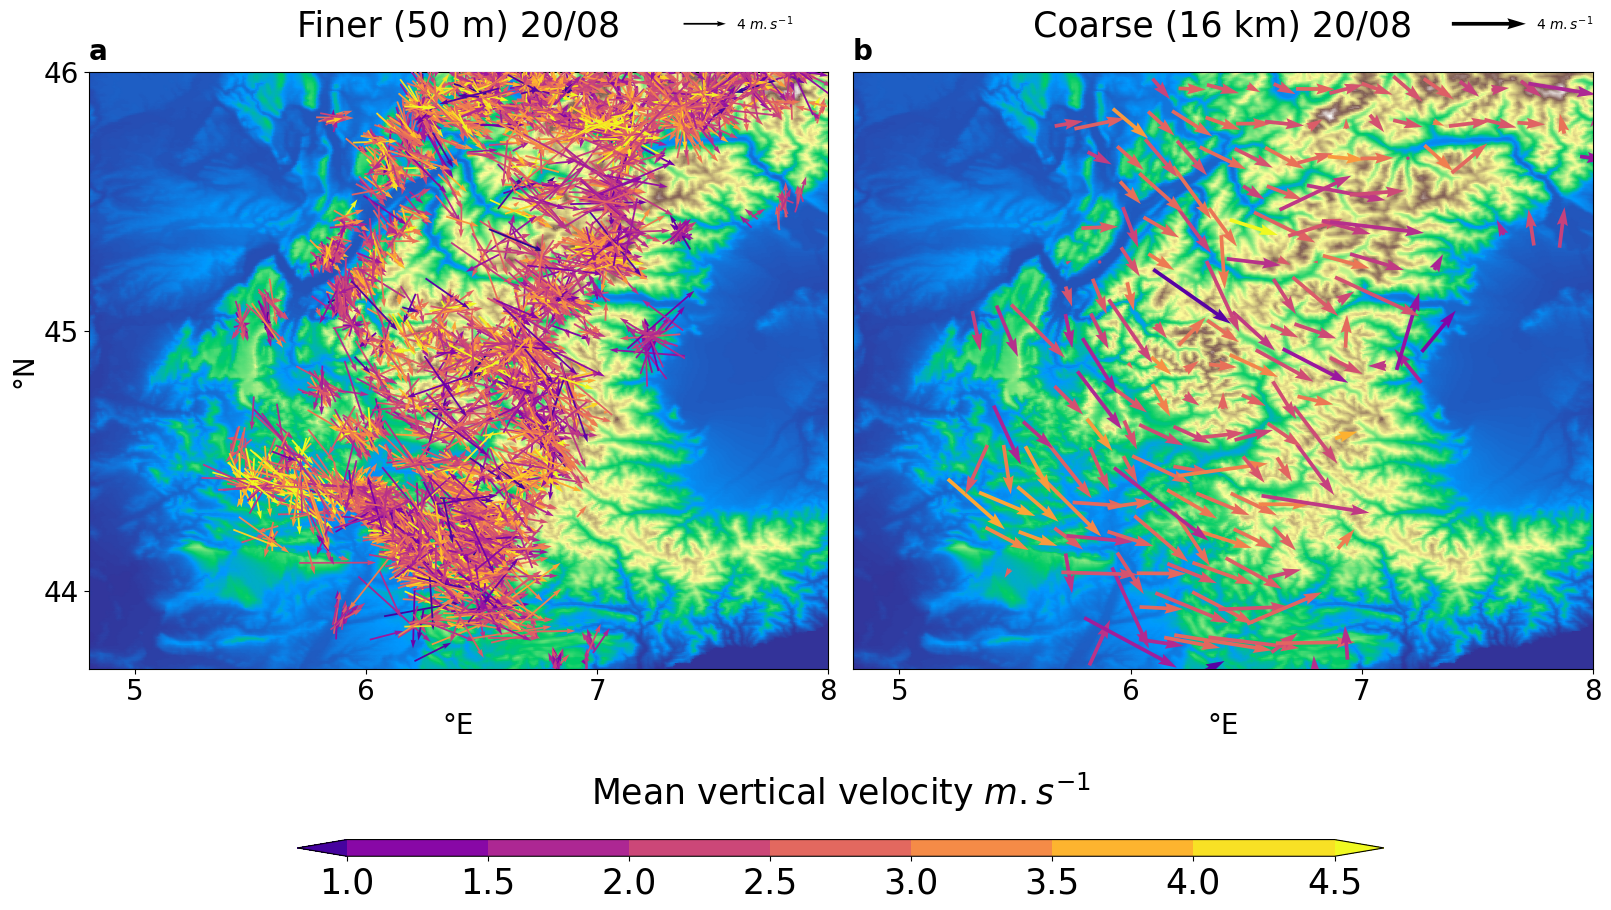

In [69]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (16,9), layout = 'constrained')

plotting_thermals_axs(20,Elevation_father,1,5,axs)

In [71]:
for i in range(6):
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (16,9), layout = 'constrained')
    plotting_thermals_axs(19+i,Elevation_father,1,5,axs)
    plt.close()

## GIF

### GIF map thermalling ascents

In [72]:
def an_image_before_GIF(xarray,elevation,ngridcell,vmin,vmax,ax,time,day):
    res = winds_coarse(xarray,ngridcell)
    
    extent = (4.8, 8, 43.4, 46.6)
    
    lons = np.linspace(extent[0],extent[1],ngridcell)
    lats = np.linspace(extent[2],extent[3],ngridcell)

    xx,yy = np.meshgrid(lons, lats)

    x = np.ravel(xx)
    y = np.ravel(yy)
    U = np.ravel(res[1])
    V = np.ravel(res[2])
    c = np.ravel(res[0])
    
    Q = ax.quiver(x,y,U,V,c,
                   pivot = 'mid',cmap = 'plasma',width = 1/150, scale = 40, zorder = 10)
    Q.set_clim(vmin=0, vmax=4.5)
    
    qk = ax.quiverkey(Q, 0.95, 0.95,4, r'$4\ m.s^{-1}$', labelpos='E',
                   coordinates='figure',labelcolor ='k')

    ax.scatter(elevation['lon'], elevation['lat'],c= elevation['elevation'], s = 10,cmap = 'terrain')

    ticks = np.arange(vmin,vmax,0.5)
    
    cbar = plt.colorbar(Q,
                ax = ax,
                ticks=ticks,
                format=mticker.FixedFormatter(ticks),
                extend='both',
                location = 'right',
                orientation='vertical',
                #label = 'Vertical velocity $m.s^{-1}$',
                fraction = 0.028,
                aspect = 35,
                boundaries = ticks
                )
    
    ax.set_xlim((extent[0],extent[1]))
    ax.set_ylim((43.7,46))
    ax.set_xlabel('°E',fontsize = 35)
    ax.set_ylabel('°N',fontsize = 35)
    plt.tick_params('x',labelsize = 30)
    plt.tick_params('y',labelsize = 30)
    
    cbar.ax.tick_params(labelsize=30) 

def make_gif_th_2():
    frames = []
    for dday in range(6):
        for nframe in range(18,49):     
            image = Image.open('T:/C2H/STAGES/LEO_BARROIS/figures/GIF_th/frame_'+str(dday+19)+'_'+str(nframe)+'.jpg')
            frames.append(image)
        
    imageio.mimsave(savefig_path+'GIF_Th/thermals_filt.gif', frames,fps=8)

def gif_th():
    for day in range(6) :
        Thermals_day = xr.open_dataset('T:/C2H/STAGES/LEO_BARROIS/netcds/Thermals__'+str(day+19)+'-08-2023_true_.nc')
    
        Thermals_day_filt = Thermals_day.where(
            (Thermals_day['vertical_speed'] < 8) & (Thermals_day['lat_speed'] < 8) & 
            (Thermals_day['lon_speed'] < 8) & (Thermals_day['vertical_speed'] > 0) & 
            (Thermals_day['lat_speed'] > - 8) & (Thermals_day['lon_speed'] > -8),
            drop = True)
        
        times = np.arange(0,20*60*60,20*60)
        
        nframe = 0
        for h in tqdm(times) :
            
            xarray_img = Thermals_day_filt.where(
                (Thermals_day_filt['enter_rawtime'] >= h) & (Thermals_day_filt['enter_rawtime'] <= h+4*60*60),
                drop = True)
        
            fig, ax = plt.subplots(figsize = (15,15), layout = 'constrained')

            an_image_before_GIF(xarray_img,Elevation_father,25,1,5,ax,h,day+19)
        
            plt.savefig(savefig_path+'GIF_Th/frame_'+str(day+19)+'_'+str(nframe)+'.jpg')
            plt.close()
            nframe +=1 

    frames = make_gif_th_2()

In [ ]:
gif_th()

### GIF time thermalling ascents

In [74]:
def plotting_time_th(day,nm):
    
    fig,ax = plt.subplots(figsize = (40,1))
    ax.fill_between(np.arange(day*24*60*60+nm*20*60,day*24*60*60+(nm+4*3)*20*60,1),np.zeros((1,4*3*20*60))[0],np.ones((1,4*3*20*60))[0],color ='r')
    
    xticks = [12*60*60*i for i in range(12)]
    xlabels = [str(i//(60*60)%24)+'h '+ str(i//(24*60*60)+19) for i in xticks]
    
    ax.set_xticks(xticks,xlabels,fontsize = 40)
    ax.set_yticks([],[])
    ax.set_xlim((0,6*24*60*60))
    ax.set_ylim((0,0.05))

def make_gif_time_th_filt():
    frames = []
    for dday in range(6):
        for nframe in range(18,49):
            image = Image.open(savefig_path+'GIF_Th/frame_'+str(dday+19)+'_'+str(nframe)+'_th_'+'time.jpg')
            frames.append(image)
        
    imageio.mimsave(savefig_path+'GIF_Th/time_th_filt.gif', frames,fps=8)

def gif_time_th():
    for day in range(6) :
        
        nframe = 0
        for nm in tqdm(range(60)) :
                plotting_time_th(day,nm)
            
                plt.savefig(savefig_path+'GIF_Th/frame_'+str(day+19)+'_'+str(nm)+'_th_'+'time.jpg')
                plt.close()
                nframe +=1 

    frames = make_gif_time_th_filt()

In [76]:
gif_time_th()

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  7.74it/s]


NameError: name 'Image' is not defined